# CUREMD RESEARCH APTITUDE TEST - QUESTION 2
Importing all the librararies used


In [35]:

import csv

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.model_selection import train_test_split 
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import seaborn as sn
from tensorflow import keras
import tensorflow as tf
import random as python_random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence

import matplotlib.pyplot as plt
import editdistance

#DATA SET
The data set is stroke prediction datat set based on a series of events

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
# Remove records with missing values
#df = df[df['bmi'].notna()]
#df
df = df[df['bmi'].notna()]
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
df = df.values

In [4]:
# Encode Data
for i in range(len(df)):
  df[i][df[i] == 'Male'] = 1
  df[i][df[i] == 'Female'] = 0
  df[i][df[i] == 'Other'] = 2

  df[i][df[i] == 'Yes'] = 1
  df[i][df[i] == 'No'] = 0

  df[i][df[i] == 'Govt_job'] = 2
  df[i][df[i] == 'Never_worked'] = 0
  df[i][df[i] == 'Private'] = 1
  df[i][df[i] == 'Self-employed'] = 3
  df[i][df[i] == 'children'] = 4

  df[i][df[i] == 'Rural'] = 1
  df[i][df[i] == 'Urban'] = 0

  df[i][df[i] == 'Unknown'] = 3
  df[i][df[i] == 'never smoked'] = 0
  df[i][df[i] == 'formerly smoked'] = 1
  df[i][df[i] == 'smokes'] = 2

In [5]:
df[0]

array([9046, 1, 67.0, 0, 1, 1, 1, 0, 228.69, 36.6, 1, 1], dtype=object)

Sepatating  positive nad negative outcomes

In [6]:
x_neg_list = np.array([x[:-1] for x in df if x[-1] == 0])
y_neg_list = np.zeros((len(x_neg_list),), dtype = int)
x_pos_list = np.array([x[:-1] for x in df if x[-1] == 1])
y_pos_list = np.ones((len(x_pos_list),), dtype = int)


In [7]:
x_pos_train, x_pos_rem, y_pos_train, y_pos_rem = train_test_split(x_pos_list, y_pos_list, train_size=0.8)  
x_pos_valid, x_pos_test, y_pos_valid, y_pos_test = train_test_split(x_pos_rem,y_pos_rem, test_size=0.5)

x_neg_train, x_neg_rem, y_neg_train, y_neg_rem = train_test_split(x_neg_list, y_neg_list, train_size=0.8)  
x_neg_valid, x_neg_test, y_neg_valid, y_neg_test = train_test_split(x_neg_rem,y_neg_rem, test_size=0.5)

x_train = np.concatenate((x_pos_train, x_neg_train),axis = 0)
y_train = np.concatenate((y_pos_train, y_neg_train),axis = 0)

x_valid = np.concatenate((x_pos_valid, x_neg_valid),axis = 0)
y_valid = np.concatenate((y_pos_valid, y_neg_valid),axis = 0)

x_test = np.concatenate((x_pos_test, x_neg_test),axis = 0)
y_test = np.concatenate((y_pos_test, y_neg_test),axis = 0)

In [8]:
x_train.shape

(3927, 11)

# Data Processing


In [9]:
X_train_padded = sequence.pad_sequences(x_train, maxlen=24, padding='post')
X_val_padded = sequence.pad_sequences(x_valid, maxlen=24, padding='post')
X_test_padded = sequence.pad_sequences(x_test, maxlen=24, padding='post')

In [10]:
X_train_padded[0]

array([20439,     1,    82,     0,     1,     1,     2,     1,   103,
          25,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [11]:
vocab_size = 1400

#Training Model

In [12]:
# Add Input layer
inputs = keras.Input(shape=(None,), dtype="int32")

# Add embedding layer
x = layers.Embedding(vocab_size, 128)(inputs)

# Add LSTM layers
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32))(x)

# Add fully connected layer
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create Model
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         179200    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         41216     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 245,313
Trainable params: 245,313
Non-trainable

In [13]:
model.compile(Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
es = EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)

In [15]:
print(type(X_train_padded))
print(type(X_val_padded))
print(type(y_train))
print(type(y_valid))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
X_train_padded.shape

(3927, 24)

In [17]:
X_val_padded.shape

(491, 24)

In [18]:
y_train.shape

(3927,)

In [19]:
y_valid.shape

(491,)

In [20]:
history = model.fit(X_train_padded, y_train, epochs = 30, batch_size = 64, validation_data=(X_val_padded, y_valid))

Epoch 1/30
62/62 [==============================] - 16s 61ms/step - loss: 0.1915 - accuracy: 0.9412 - val_loss: 0.1732 - val_accuracy: 0.9572
Epoch 2/30
62/62 [==============================] - 2s 32ms/step - loss: 0.1558 - accuracy: 0.9575 - val_loss: 0.1790 - val_accuracy: 0.9572
Epoch 3/30
62/62 [==============================] - 2s 32ms/step - loss: 0.1506 - accuracy: 0.9575 - val_loss: 0.1634 - val_accuracy: 0.9572
Epoch 4/30
62/62 [==============================] - 2s 30ms/step - loss: 0.1429 - accuracy: 0.9575 - val_loss: 0.1603 - val_accuracy: 0.9572
Epoch 5/30
62/62 [==============================] - 2s 31ms/step - loss: 0.1352 - accuracy: 0.9582 - val_loss: 0.1710 - val_accuracy: 0.9572
Epoch 6/30
62/62 [==============================] - 2s 31ms/step - loss: 0.1270 - accuracy: 0.9587 - val_loss: 0.1719 - val_accuracy: 0.9572
Epoch 7/30
62/62 [==============================] - 2s 30ms/step - loss: 0.1236 - accuracy: 0.9585 - val_loss: 0.1606 - val_accuracy: 0.9572
Epoch 8/30
6

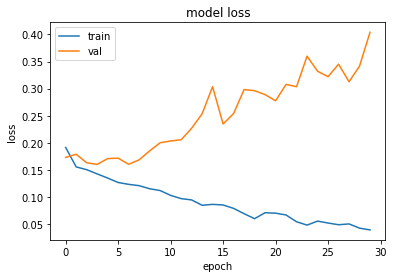

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

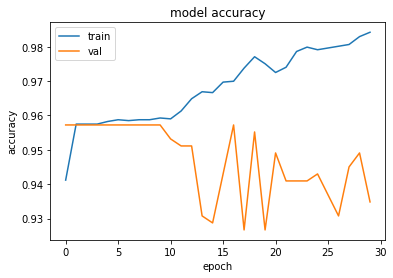

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Evaluating Model

In [23]:
y_pred = model.predict(X_test_padded)
y_pred = np.round(y_pred)

In [29]:
acc = accuracy_score(y_test, y_pred)

In [41]:
cm = confusion_matrix(y_test, y_pred)

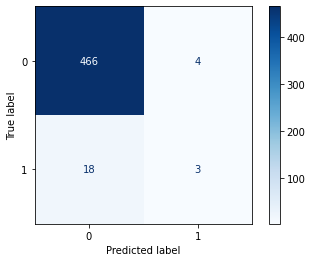

In [42]:
labels_cm = [0, 1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

#Get the negative predictions


In [49]:
X_pred_negative = X_test_padded[y_pred.reshape(y_pred.shape[0]) == 0]
X_pred_negative


array([[17004,     0,    70, ...,     0,     0,     0],
       [45277,     0,    74, ...,     0,     0,     0],
       [ 4219,     1,    71, ...,     0,     0,     0],
       ...,
       [ 2893,     0,     7, ...,     0,     0,     0],
       [15964,     0,    64, ...,     0,     0,     0],
       [23459,     0,    47, ...,     0,     0,     0]], dtype=int32)

In [50]:
X_pred_negative.shape

(484, 24)

#Modification using nearest neighbours

In [52]:
nn_model = NearestNeighbors(n_neighbors = 1, metric='hamming')

In [53]:
# Train data on true lables
X_target_label = X_train_padded[y_train == 1]

In [54]:
nn_model.fit(X_target_label)

NearestNeighbors(metric='hamming', n_neighbors=1)

In [55]:
# Find the closest neighbor as a counterfactual
closest = nn_model.kneighbors(X_pred_negative, return_distance = False)
trans_results_nn = X_target_label[closest[:, 0]]

trans_results_nn[0]

array([17308,     0,    72,     1,     0,     1,     1,     0,   221,
          30,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

#Comparison between fraction of valid CFs

In [56]:
y_pred = model.predict(X_test_padded)

In [58]:
fraction_success = np.sum(y_pred > 0.5)/y_pred.shape[0]
print(round(fraction_success, 4))

0.0143


In [59]:
# Counterfactual Results
y_pred_new = model.predict(trans_results_nn)

In [60]:
fraction_success_new = np.sum(y_pred_new > 0.5)/y_pred_new.shape[0]
print(round(fraction_success_new, 4))

0.6632


#Local outlier factor (LOF score)

In [61]:
clf = LocalOutlierFactor(n_neighbors = 20, novelty = True, contamination = 0.1)
clf.fit(X_target_label)

LocalOutlierFactor(contamination=0.1, novelty=True)

In [62]:
# Simple Results
y_pred_test = clf.predict(X_test_padded)
n_error_test = y_pred_test[y_pred_test == -1].size

In [63]:
outlier_score_test = n_error_test/X_val_padded.shape[0]
outlier_score_test

0.0855397148676171

In [64]:
# Counterfactual Results
y_pred_test_new = clf.predict(trans_results_nn)
n_error_test_new = y_pred_test_new[y_pred_test_new == -1].size

outlier_score_test = n_error_test_new / y_pred_test_new.shape[0]
print(round(outlier_score_test, 4))

0.0455


#Edit distance (Levenshtein)

In [71]:
def get_edit_distance(original, transformed):
    edit_distance_pair = [editdistance.eval(o, t) for o, t in zip(original.tolist(), transformed.tolist())]
    edit_score = np.mean(edit_distance_pair)
    
    return round(edit_score, 4)

In [72]:
get_edit_distance(X_test_padded, X_pred_negative)

6.8678

In [73]:
get_edit_distance(trans_results_nn, X_pred_negative)

4.1467